<a href="https://colab.research.google.com/github/hwangsae91/project_so/blob/master/exploration/221011/%5BExp_08%5D20221011.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# google colab전용
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Mecab 설치를 위한 환경구성
import os

# install konlpy, jdk, JPype
!pip install konlpy
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip3 install JPype1-py3

# install mecab-ko
os.chdir('/tmp/')
!curl -LO https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
!tar zxfv mecab-0.996-ko-0.9.2.tar.gz
os.chdir('/tmp/mecab-0.996-ko-0.9.2')
!./configure
!make
!make check
!make install

# install mecab-ko-dic
!apt-get install automake
os.chdir('/tmp')
!curl -LO https://bitbucket.org/eunjeon/mecab-ko-dic/downloads/mecab-ko-dic-2.1.1-20180720.tar.gz
!tar -zxvf mecab-ko-dic-2.1.1-20180720.tar.gz
os.chdir('/tmp/mecab-ko-dic-2.1.1-20180720')
!./autogen.sh
!./configure
!make
!make install

# install mecab-python
os.chdir('/content')
!git clone https://bitbucket.org/eunjeon/mecab-python-0.996.git
os.chdir('/content/mecab-python-0.996')
!python3 setup.py build
!python3 setup.py install

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 4.7 MB/s 
     |████████████████████████████████| 453 kB 78.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.8 MB/s 
  Created wheel for JPype1-py3: filename=JPype1_py3-0.5.5.4-cp37-cp37m-linux_x86_64.whl size=2698711 sha256=51e643f2489930c9a38d5044a6b40f335f89b373266475e29eeff14774dfc167
  Stored in directory: /root/.cache/pip/wheels/e7/d1/09/f55dca0203b0691945bdf0f63d486a0b4d4e5ec4bd78a2502e
Successfully built JPype1-py3
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1381k  100 1381k    0     0  1471k      0 --:--:-- --:--:-- --:--:-- 8033k
meca

# exploration 8번째 과제</br>
@ 황한용(3기/쏘카)

## 라이브러리 선언

In [3]:
import pandas as pd
import gensim
import konlpy
import numpy as np
import tensorflow as tf

from collections import Counter
from gensim.models.keyedvectors import Word2VecKeyedVectors
import matplotlib.pyplot as plt
from konlpy.tag import Mecab
from pathlib import Path
from sklearn.model_selection import train_test_split
from typing import Dict, Tuple

## 상수선언

In [4]:
BASE_PATH = "/content/drive/MyDrive/Colab Notebooks/data/sentiment_classification" # 데이터 기본경로
DATA_PATH  = BASE_PATH + "/data"
MODEL_PATH = BASE_PATH + "/model/word2vec_ko.model"
STEP_WORDS = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'] # 불용어
MAX_NUM_WORDS = 10000 # 최대 사전 단어갯수
FEATURE_DATA = ["document"]
WORD_VECTOR_DIM = 16 # 단어 백터 차원수
pad_seq_kwargs = {
    "value":None # 추후 추가예정
    , "padding":"post"
    , "maxlen":None # 추후 추가예정
}
TRAIN_TEST_SPLIT_KWARGS = {
    "test_size":0.4, "random_state":2022
}
fit_kwargs = {
    "epochs":10 # epoch 횟수
    ,"validation_data": None # 추후 추가예정
    , "shuffle" : True # epoch당 셔플을 할지의 여부
    , "verbose":1
}
tokenizer = Mecab()

## 함수

In [5]:
def load_data(
    train_data:pd.DataFrame
    , test_data:pd.DataFrame
    , step_words:list=STEP_WORDS
    , num_words:int=MAX_NUM_WORDS
) -> Tuple[
            np.ndarray
            , np.ndarray
            , np.ndarray
            , np.ndarray
            , Dict[int,str]
           , Dict[str,int]
        ]:
    """
    다음과 같은 전처리 후
    `train data(feature, target)`, `test data(feature, target)`, `단어사전(str기반, index기반)`
    을 리턴한다.

    - 데이터의 중복 제거
    - `NaN` 결측치 제거
    - 한국어 토크나이저로 토큰화
    - 불용어(`stop_words`) 제거
    - 사전`word_to_index` 구성
    - 텍스트 스트링을 사전 인덱스 스트링으로 변환

    Parameters
    ----------
    train_data : DataFrame
        학습 데이터
    train_data : DataFrame
        테스트 데이터
    step_words : list, default = `MAX_NUM_WORDS`
        불용어
    num_words : int, default = `MAX_NUM_WORDS`
        단어사전의 최대 단어 갯수

    Returns
    -------
    X_train : ndarray
        train feature data
    y_train : ndarray
        train target data
    X_test : ndarray
        test feature data
    y_test : ndarray
        test target data
    word_to_index : dict
        단어사전
    index_to_word : dict
        인덱스 기반 단어사전
    """
    # 1.
    train_data.drop_duplicates(subset=FEATURE_DATA, inplace=True)
    test_data.drop_duplicates(subset=FEATURE_DATA, inplace=True)

    # 2.
    train_data.dropna(how='any', inplace=True)
    test_data.dropna(how='any', inplace=True)

    # 3.
    X_train = [
        [word for word in tokenizer.morphs(sentence) if not word in step_words]
        for sentence in train_data['document']
    ]

    X_test = [
        [word for word in tokenizer.morphs(sentence) if not word in step_words]
        for sentence in test_data['document']
    ]
    
    # 4.
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>','<UNUSED>'] + [key for key, _ in counter]

    # 5.
    word_to_index = {word:index for index, word in enumerate(vocab)}
    index_to_word = {index:word for word, index in word_to_index.items()}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index, index_to_word

####################################### 제공 함수 #######################################

# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 메인

### IMDB 데이터셋

In [6]:
train_data = pd.read_table(DATA_PATH + "/ratings_train.txt")
test_data = pd.read_table(DATA_PATH + "/ratings_test.txt")
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


데이터에 대한 설명은 아래와 같다.</br>
- id: The review id, provieded by Naver
- document: The actual review
- label: The sentiment class of the review. (0: negative, 1: positive)

In [7]:
X_train, y_train, X_test, y_test, word_to_index, index_to_word = load_data(train_data, test_data)

print(f"X_train len:{len(X_train)}")
print(f"X_test len:{len(X_test)}")

X_train len:146182
X_test len:49157


In [8]:
num_tokens = np.array(list(map(len,list(X_train) + list(X_test))))
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_seq_kwargs.update({
    "value":word_to_index["<PAD>"]
    , "maxlen":maxlen
})# padding 설정

문장길이 평균 :  15.969376315021577
문장길이 최대 :  116
문장길이 표준편차 :  12.843535456326455
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [9]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, **pad_seq_kwargs)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, **pad_seq_kwargs)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, **TRAIN_TEST_SPLIT_KWARGS)
fit_kwargs["validation_data"] = (X_val, y_val)

### 한국어 Word2Vec 임베딩

In [15]:
word_vectors = Word2VecKeyedVectors.load(MODEL_PATH)

In [10]:
model_list = []

# CNN 중 max pooling만 존제하는 model 설계
model_maxpool = tf.keras.Sequential(name = "maxpool_model")
model_maxpool.add(tf.keras.layers.Embedding(MAX_NUM_WORDS, WORD_VECTOR_DIM, input_shape=(None,)))
model_maxpool.add(tf.keras.layers.GlobalMaxPooling1D())
model_maxpool.add(tf.keras.layers.Dense(8, activation='relu'))
model_maxpool.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_list.append(model_maxpool)

In [11]:
# CNN 1d model 설계
model_CNN = tf.keras.Sequential(name = "CNN_model")
model_CNN.add(tf.keras.layers.Embedding(MAX_NUM_WORDS, WORD_VECTOR_DIM, input_shape=(None,)))
model_CNN.add(tf.keras.layers.Dropout(rate=0.2))
model_CNN.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_CNN.add(tf.keras.layers.MaxPooling1D(5))
model_CNN.add(tf.keras.layers.Dropout(rate=0.2))
model_CNN.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_CNN.add(tf.keras.layers.GlobalMaxPooling1D())
model_CNN.add(tf.keras.layers.Dense(8, activation='relu'))
model_CNN.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_list.append(model_CNN)

In [12]:
# RNN model 설계
model_RNN = tf.keras.Sequential(name = "RNN_model")
model_RNN.add(tf.keras.layers.Embedding(MAX_NUM_WORDS, WORD_VECTOR_DIM, input_shape=(None,)))
model_RNN.add(tf.keras.layers.LSTM(8))
model_RNN.add(tf.keras.layers.Dense(8, activation='relu'))
model_RNN.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_list.append(model_RNN)

maxpool_model start
Epoch 1/10
2741/2741 [==============================] - 15s 4ms/step - loss: 0.6852 - accuracy: 0.5515 - val_loss: 0.6707 - val_accuracy: 0.6594
Epoch 2/10
2741/2741 [==============================] - 10s 4ms/step - loss: 0.6417 - accuracy: 0.7472 - val_loss: 0.6096 - val_accuracy: 0.7719
Epoch 3/10
2741/2741 [==============================] - 10s 4ms/step - loss: 0.5747 - accuracy: 0.7874 - val_loss: 0.5423 - val_accuracy: 0.7902
Epoch 4/10
2741/2741 [==============================] - 10s 4ms/step - loss: 0.5093 - accuracy: 0.8032 - val_loss: 0.4861 - val_accuracy: 0.8024
Epoch 5/10
2741/2741 [==============================] - 10s 4ms/step - loss: 0.4585 - accuracy: 0.8149 - val_loss: 0.4472 - val_accuracy: 0.8109
Epoch 6/10
2741/2741 [==============================] - 10s 4ms/step - loss: 0.4222 - accuracy: 0.8254 - val_loss: 0.4216 - val_accuracy: 0.8170
Epoch 7/10
2741/2741 [==============================] - 10s 4ms/step - loss: 0.3964 - accuracy: 0.8335 - val_l

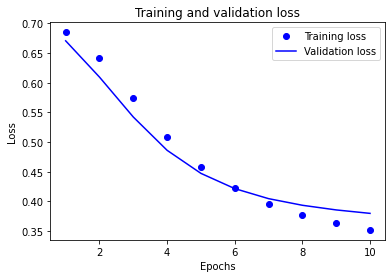

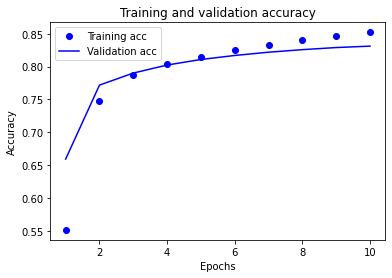

1537/1537 - 2s - loss: 0.3815 - accuracy: 0.8301 - 2s/epoch - 1ms/step
[0.3815351724624634, 0.8301157355308533]
maxpool_model end

CNN_model start
Epoch 1/10
2741/2741 [==============================] - 21s 5ms/step - loss: 0.6922 - accuracy: 0.5292 - val_loss: 0.6870 - val_accuracy: 0.6529
Epoch 2/10
2741/2741 [==============================] - 14s 5ms/step - loss: 0.6066 - accuracy: 0.7173 - val_loss: 0.4837 - val_accuracy: 0.7893
Epoch 3/10
2741/2741 [==============================] - 13s 5ms/step - loss: 0.4492 - accuracy: 0.7962 - val_loss: 0.4139 - val_accuracy: 0.8163
Epoch 4/10
2741/2741 [==============================] - 13s 5ms/step - loss: 0.4049 - accuracy: 0.8204 - val_loss: 0.3910 - val_accuracy: 0.8266
Epoch 5/10
2741/2741 [==============================] - 13s 5ms/step - loss: 0.3822 - accuracy: 0.8339 - val_loss: 0.3777 - val_accuracy: 0.8353
Epoch 6/10
2741/2741 [==============================] - 13s 5ms/step - loss: 0.3681 - accuracy: 0.8418 - val_loss: 0.3714 - val_

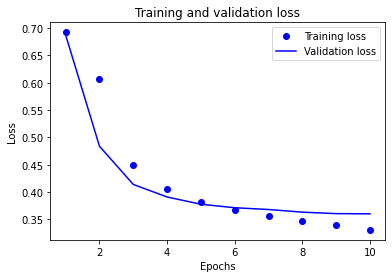

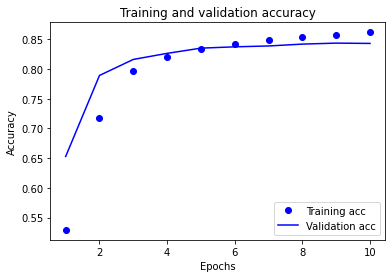

1537/1537 - 3s - loss: 0.3650 - accuracy: 0.8428 - 3s/epoch - 2ms/step
[0.36502259969711304, 0.8428301215171814]
CNN_model end

RNN_model start
Epoch 1/10
2741/2741 [==============================] - 21s 7ms/step - loss: 0.6930 - accuracy: 0.5112 - val_loss: 0.6928 - val_accuracy: 0.5218
Epoch 2/10
2741/2741 [==============================] - 18s 7ms/step - loss: 0.5820 - accuracy: 0.7031 - val_loss: 0.4754 - val_accuracy: 0.7997
Epoch 3/10
2741/2741 [==============================] - 18s 7ms/step - loss: 0.4373 - accuracy: 0.8215 - val_loss: 0.4284 - val_accuracy: 0.8193
Epoch 4/10
2741/2741 [==============================] - 18s 7ms/step - loss: 0.3933 - accuracy: 0.8422 - val_loss: 0.4051 - val_accuracy: 0.8282
Epoch 5/10
2741/2741 [==============================] - 18s 7ms/step - loss: 0.3672 - accuracy: 0.8546 - val_loss: 0.3929 - val_accuracy: 0.8326
Epoch 6/10
2741/2741 [==============================] - 18s 7ms/step - loss: 0.3498 - accuracy: 0.8626 - val_loss: 0.3858 - val_acc

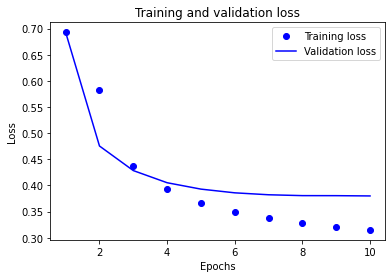

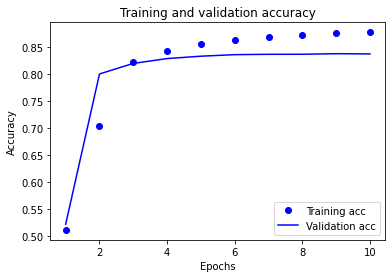

1537/1537 - 4s - loss: 0.3839 - accuracy: 0.8370 - 4s/epoch - 2ms/step
[0.3839060068130493, 0.8369510173797607]
RNN_model end



In [13]:
for model in model_list:
    print(f"{model.name} start")
    model.compile(optimizer=tf.keras.optimizers.Adam(
                        learning_rate=0.00005 # running rate
                )
                ,loss='binary_crossentropy'
                ,metrics=['accuracy'])

    history_dict = model.fit(
                        X_train
                        , y_train
                        , **fit_kwargs
                    ).history

    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    # "bo"는 "파란색 점"입니다
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b는 "파란 실선"입니다
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

    plt.clf()   # 그림을 초기화합니다

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    # 테스트셋을 통한 모델 평가
    results = model.evaluate(X_test, y_test, verbose=2)
    print(results)

    print(f"{model.name} end\n")